# Event detection

In this notebook I try and detect events for waterbodies.

In [2]:
%matplotlib widget
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.filters
import scipy.signal
import scipy.optimize as opt
from sklearn.decomposition import PCA
import sklearn.svm
import geopandas as gpd
from tqdm.notebook import tqdm
import sklearn.cluster

In [3]:
history = np.load('history_murray_full_norivers.npy')  # from WaterbodyClustering.ipynb

In [9]:
times = np.load('time_axis_murray_full_norivers.npy')

In [10]:
history.shape

(9081, 12389)

In [5]:
waterbodies = gpd.read_file('waterbodies_murray_norivers.geojson')

These water histories are filled with inflow and outflow events - times where there was significant increase or decrease in surface area. One really obvious way to find these is differentiation:

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(times, history[1000])
plt.ylabel('$W$')
plt.subplot(2, 1, 2)
plt.plot(times, np.gradient(history[1000]))
plt.xlabel('Time slice')
plt.xlabel('$t$')
plt.ylabel('$\\nabla W$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, '$\\nabla W$')

This is pretty noisy, because our data are pretty noisy. Of course, we could smooth it:

In [53]:
plt.figure(figsize=(10, 5))
smooth = scipy.ndimage.filters.gaussian_filter1d(history[1000], sigma=14)
plt.subplot(2, 1, 1)
plt.plot(smooth)
plt.ylabel('$W$')
plt.subplot(2, 1, 2)
grad = np.gradient(smooth)
plt.plot(grad)
plt.ylabel('$\\nabla W$')
plt.xlabel('$t$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, '$t$')

Peak detection on the gradient then tells you when a significant drop or increase happened (and the sensitivity of this is mediated by the smoothness):

In [54]:
peaks, _ = scipy.signal.find_peaks(grad, prominence=0.1)
troughs, _ = scipy.signal.find_peaks(-grad, prominence=0.1)

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(times, smooth)
plt.scatter(times[peaks], smooth[peaks], c='red', marker='o')
plt.scatter(times[troughs], smooth[troughs], c='purple', marker='*')
plt.ylabel('$W$')
plt.subplot(2, 1, 2)
grad = np.gradient(smooth)
plt.plot(times, grad)
plt.scatter(times[peaks], grad[peaks], c='red', marker='o')
plt.scatter(times[troughs], grad[troughs], c='purple', marker='*')
plt.ylabel('$\\nabla W$')
plt.xlabel('$t$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, '$t$')

These seem largely seasonal:

In [18]:
def find_peak_events(history, sigma: 'days'=10):
    smooth = scipy.ndimage.filters.gaussian_filter1d(history, sigma=sigma)
    grad = np.gradient(smooth)
    peaks, _ = scipy.signal.find_peaks(grad, prominence=0.1)
    troughs, _ = scipy.signal.find_peaks(-grad, prominence=0.1)
    return {
        'peaks': peaks,
        'troughs': troughs,
        'peak_heights': smooth[peaks],
        'trough_depths': smooth[troughs],
        'peak_grads': grad[peaks],
        'trough_grads': grad[troughs],
    }

In [19]:
peak_events = [find_peak_events(h) for h in tqdm(history)]

In [20]:
all_peaks = [pe['peaks'] for pe in peak_events]

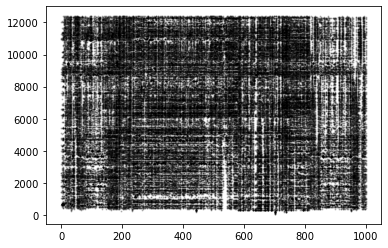

In [21]:
for i, p in enumerate(all_peaks[:1000]):
    plt.scatter([i] * len(p), p, marker='o', c='k', s=1, alpha=0.2)

You can quite clearly see the seasons running horizontally. Of course, these shouldn't line up exactly since this is a river system - some places presumably aren't fed directly by rainfall. We should get offsets in the peaks. You can also see this pretty clearly if you just look at all the water histories stacked:

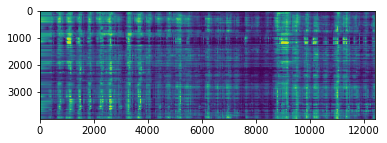

In [22]:
plt.imshow(history[:4000])

We want to find the offset that minimises the distance between peaks, somehow. This is a kind of silly problem. Let's say we have $N$ water histories $\vec w_i, i \in 1 \dots N$. Each of these has $P_i$ peaks $p_{ij}, j \in 1, \dots, P_i$. We can add an offset $a_i$ to each history. The resulting set of peaks looks like this:

$$
    p'_{ij} = p_{ij} + a_i.
$$

We want to minimise the distance between nearby peaks... let's say we want to minimise the average distance between peak $j$ and its closest peak in each other water history. So for a water history $i$ and peak $j$ we have a distance:

\begin{align*}
    d_{ij} &= \mathbb E_{k \in 1, \dots, N}\left[\underset{\ell \in 1, \dots, P_k}{\mathrm{min}} ||p'_{ij} - p'_{k\ell}||\right]\\
        &= \mathbb E_{k \in 1, \dots, N}\left[\underset{\ell \in 1, \dots, P_k}{\mathrm{min}} ||a_i + p_{ij} - a_k - p'_{k\ell}||\right]\\
        &= \frac{1}{N} \sum_{k = 1}^N \underset{\ell \in 1, \dots, P_k}{\mathrm{min}} ||a_i + p_{ij} - a_k - p'_{k\ell}||\\
\end{align*}

To minimise *all* such distances, we could add them together and get the following optimisation problem:

$$
    \underset{\vec a}{\min} \sum_{i = 1}^N \sum_{j = 1}^{P_i} d_{ij} = \frac{1}{N} \underset{\vec a}{\min} \sum_{i = 1}^N \sum_{k = 1}^N \sum_{j = 1}^{P_i} \underset{\ell \in 1, \dots, P_k}{\mathrm{min}} ||a_i + p_{ij} - a_k - p'_{k\ell}||
$$

That min isn't differentiable, which makes me very sad. We could replace it with a softmax:
\begin{align*}
    &\frac{1}{N} \underset{\vec a}{\min} \sum_{i = 1}^N \sum_{k = 1}^N \sum_{j = 1}^{P_i} ||a_i + p_{ij} - a_k - \vec p'_k||^T \mathrm{softmax} (-||a_i + p_{ij} - a_k - \vec p'_{k}||)\\
    &= \frac{1}{N} \underset{\vec a}{\min} \sum_{i = 1}^N \sum_{k = 1}^N \sum_{j = 1}^{P_i} \sum_{\ell = 1}^{P_k} ||a_i + p_{ij} - a_k - p_{k\ell}|| \frac{e^{\beta||a_i + p_{ij} - a_k - p'_{k\ell}||}}{\sum_{l = 1}^{P_k} e^{\beta||a_i + p_{ij} - a_k - p'_{kl}||}}\\
\end{align*}

The derivative is not nice though and there's not anything interesting we can do with it. I suppose we could write this out in Jax and see how it fares, but Jax is broken on the VDI right now. Instead, let's approximate it.

$$
    \underset{\vec a}{\min} \sum_{i = 1}^N \sum_{j = 1}^{P_i} d_{ij} \approx \underset{\vec a}{\min} \sum_{i = 1}^N \sum_{j = 1}^{P_i} \underset{\ell \in 1, \dots, \overline P}{\mathrm{min}} ||a_i + p_{ij} - \overline p_{\ell}||
$$

where $\overline p_\ell$ are peaks in the *average* water history. The idea here is that *on average* peaks appear in the right spots.

In [23]:
average_history = np.nanmean(history, axis=0)

In [24]:
average_events = find_peak_events(average_history)

In [25]:
def target(a_i, i):
    min_dists = abs(a_i + all_peaks[i][:, None] - average_events['peaks'][None, :]).min(axis=1)
    return min_dists.sum()

We can now optimise all the $a$ values. We'll assume the maximum offset is 50, roughly one year.

In [26]:
offsets = []
for i in tqdm(range(1000)):
    targets = [target(k, 0) for k in range(50)]
    offsets.append(np.argmin(targets))

In [27]:
(np.array(offsets) > 0).any()

False

As you can see, this has no effect at all and the best offset is zero. Great?

Let's try to represent these peaks and troughs as features. The only obvious way to do this is with a one-hot vector with an element for each timestep:

In [28]:
one_hot_peaks = np.zeros(history.shape)
one_hot_troughs = np.zeros(history.shape)

In [29]:
for i in tqdm(range(history.shape[0])):
    one_hot_peaks[i, peak_events[i]['peaks']] = 1
    one_hot_troughs[i, peak_events[i]['troughs']] = 1

This of course lacks time structure. A kernel would work for imposing such structure, or we could do something equivalent and easier - we can Gaussian blur along the time axis, which will have the effect of "spreading out" the ones in the one-hot vector. This means if two objects have *very slightly different* peaks, then they will have *very slightly different* Gaussians, and the overlap will be high. I chose an arbitrary sigma of 5. This is a parameter we need to figure out later, but should be large enough that the "same" peak event overlaps and small enough that "different" peak events do not. It is, loosely speaking, measured in days.

In [30]:
blurred_peaks = scipy.ndimage.gaussian_filter1d(one_hot_peaks, axis=1, sigma=14)
blurred_troughs = scipy.ndimage.gaussian_filter1d(one_hot_troughs, axis=1, sigma=14)

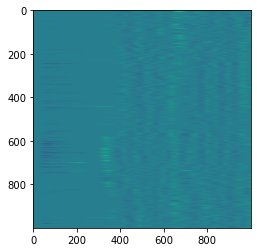

In [31]:
plt.imshow(blurred_peaks[:1000, :1000] - blurred_troughs[:1000, :1000])

We can now do all kinds of delightful things. Let's try PCA:

In [32]:
blurred_features = np.concatenate([blurred_peaks, blurred_troughs], axis=1)

In [33]:
pca = PCA(n_components=30)

In [34]:
f_pca = pca.fit_transform(blurred_features)

In [35]:
river_region_nums = np.nan_to_num(waterbodies.RivRegNum.astype(float), nan=-1).astype(int)

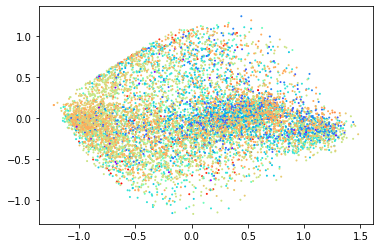

In [36]:
plt.figure()
plt.scatter(f_pca[:, 0], f_pca[:, 1], s=1, c=river_region_nums, cmap='rainbow')

We can try outlier detection:

In [37]:
import sklearn.svm
ocsvm = sklearn.svm.OneClassSVM()

In [38]:
predictions = ocsvm.fit_predict(f_pca)

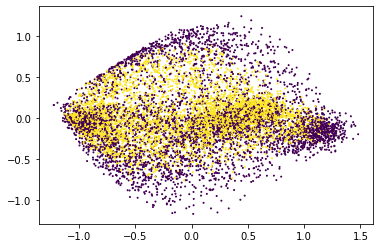

In [39]:
plt.scatter(f_pca[:, 0], f_pca[:, 1], s=1, c=predictions)

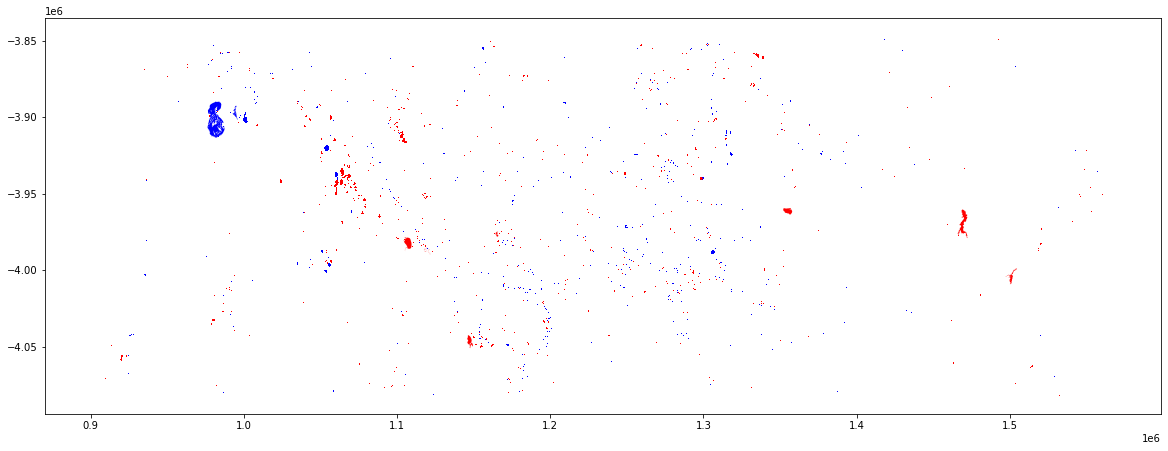

In [40]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 1, 1)
waterbodies.plot(column=predictions, cmap='bwr', ax=ax)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

We can also repeat our t-SNE.

In [42]:
import sklearn.manifold

In [44]:
tsne = sklearn.manifold.TSNE(verbose=True, perplexity=50)
f_tsne = tsne.fit_transform(f_pca)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9081 samples in 0.033s...
[t-SNE] Computed neighbors for 9081 samples in 4.278s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9081
[t-SNE] Computed conditional probabilities for sample 2000 / 9081
[t-SNE] Computed conditional probabilities for sample 3000 / 9081
[t-SNE] Computed conditional probabilities for sample 4000 / 9081
[t-SNE] Computed conditional probabilities for sample 5000 / 9081
[t-SNE] Computed conditional probabilities for sample 6000 / 9081
[t-SNE] Computed conditional probabilities for sample 7000 / 9081
[t-SNE] Computed conditional probabilities for sample 8000 / 9081
[t-SNE] Computed conditional probabilities for sample 9000 / 9081
[t-SNE] Computed conditional probabilities for sample 9081 / 9081
[t-SNE] Mean sigma: 0.240434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.136414
[t-SNE] KL divergence after 1000 iterations: 1.747509


The mean sigma is *way* lower, incidentally, but we get really similar (if a little lower) KL divergence to the non-event version of t-SNE.

In [45]:
names = dict(zip(waterbodies.RivRegNum.astype(int), waterbodies.RivRegName))

In [47]:
%matplotlib widget
plt.figure(figsize=(8, 8))
xs = np.arange(min(names), max(names))
plt.scatter(f_tsne[:, 0], f_tsne[:, 1], s=(waterbodies.area / 0.5e3) ** 0.5,
            edgecolor='None', c=waterbodies.RivRegNum.astype(int), cmap='tab20', norm=matplotlib.colors.BoundaryNorm(xs, len(xs) + 1))
cb = plt.colorbar()
cb.set_ticks(xs + 0.5)
cb.set_ticklabels([names.get(i, '') for i in xs])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …